In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys 

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Set plot style
sns.set(style="whitegrid")
import src.data_prep
importlib.reload(src.data_prep)

from src.data_prep import split_time_series


In [5]:
from src.data_cleaning import clean_price_data
import pandas as pd

tsla_df = pd.read_csv('../data/raw/TSLA.csv', index_col=0, parse_dates=True)
bnd_df = pd.read_csv('../data/raw/BND.csv', index_col=0, parse_dates=True)
spy_df = pd.read_csv('../data/raw/SPY.csv', index_col=0, parse_dates=True)

tsla_clean = clean_price_data(tsla_df)
bnd_clean = clean_price_data(bnd_df)
spy_clean = clean_price_data(spy_df)
# Move index to a column named 'Date'
tsla_clean = tsla_clean.reset_index()

# Optional: basic cleaning
tsla_clean = tsla_clean.dropna(subset=['Close'])

# Check columns
print(tsla_clean.columns)
# Now check types
print(tsla_clean.dtypes)


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object


In [6]:
train_df, test_df = split_time_series(
    tsla_clean,
    date_column='Date',
    split_date='2024-01-01',
    save_path='../data/processed'
)

In [13]:
import os
import sys 

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

from src.arima_model import check_stationarity, fit_arima_model, forecast_and_plot

In [14]:
import pandas as pd

tsla_clean = pd.read_csv('../data/processed/tsla_clean.csv', parse_dates=['Date'], index_col='Date')
train_df=pd.read_csv('../data/processed/train.csv', parse_dates=['Date'], index_col='Date')

ADF Statistic: -0.9292166691301588
p-value: 0.7781987704764382
Series is non-stationary; differencing is recommended.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12837.345, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12837.562, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12837.129, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12837.211, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12836.663, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12838.371, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.728 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2024
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6417.331
Date:                Mon, 11 Aug 2025   AIC                          12836.663
Time:                        11:03:29   BIC 

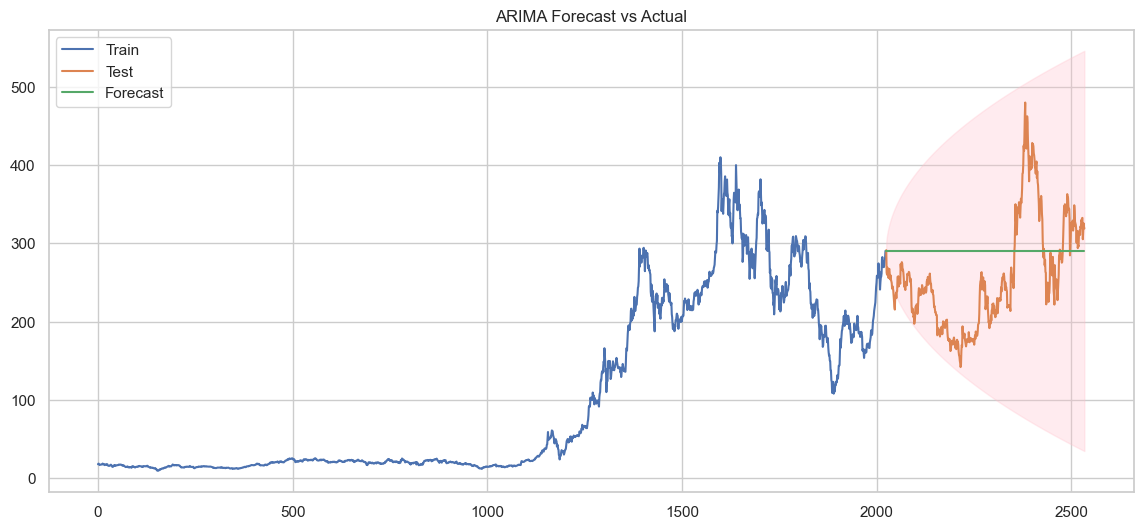

In [16]:
from src.arima_model import check_stationarity, fit_arima_model, forecast_and_plot

# Assuming train_df and test_df are already loaded
train_close = train_df['Close']
test_close = test_df['Close']
# Assuming tsla_clean is your DataFrame with a DateTimeIndex and 'Close' price column

train_df = tsla_clean.loc[:'2023-12-31']
test_df = tsla_clean.loc['2024-01-01':]
check_stationarity(train_close)
model = fit_arima_model(train_close)
forecast_and_plot(model, train_close, test_close)

In [18]:
print(tsla_clean.index.min(), tsla_clean.index.max())
print(train_df.index.min(), train_df.index.max())
print(test_df.index.min(), test_df.index.max())

2015-07-02 00:00:00 2025-07-30 00:00:00
2015-07-01 00:00:00 2023-12-29 00:00:00
2140 2534


In [20]:
print(tsla_clean.index)  # see if index is datetime type
print(tsla_clean.index.name)  # likely 'Date' or None


DatetimeIndex(['2015-07-02', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10', '2015-07-13', '2015-07-14',
               '2015-07-15', '2015-07-16',
               ...
               '2025-07-17', '2025-07-18', '2025-07-21', '2025-07-22',
               '2025-07-23', '2025-07-24', '2025-07-25', '2025-07-28',
               '2025-07-29', '2025-07-30'],
              dtype='datetime64[ns]', name='Date', length=2534, freq=None)
Date


In [21]:
split_date = pd.to_datetime('2024-01-01')
train_df = tsla_clean.loc[tsla_clean.index < split_date]
test_df = tsla_clean.loc[tsla_clean.index >= split_date]


In [22]:
split_date = pd.to_datetime('2024-01-01')

train_df = tsla_clean.loc[tsla_clean.index < split_date]
test_df = tsla_clean.loc[tsla_clean.index >= split_date]

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (2139, 10)
Test shape: (395, 10)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2139
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6819.539
Date:                Mon, 11 Aug 2025   AIC                          13641.078
Time:                        08:41:51   BIC                          13646.745
Sample:                             0   HQIC                         13643.152
                               - 2139                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        34.5188      0.413     83.508      0.000      33.709      35.329
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):             10918.54
Prob(Q):                              0.16   Pr

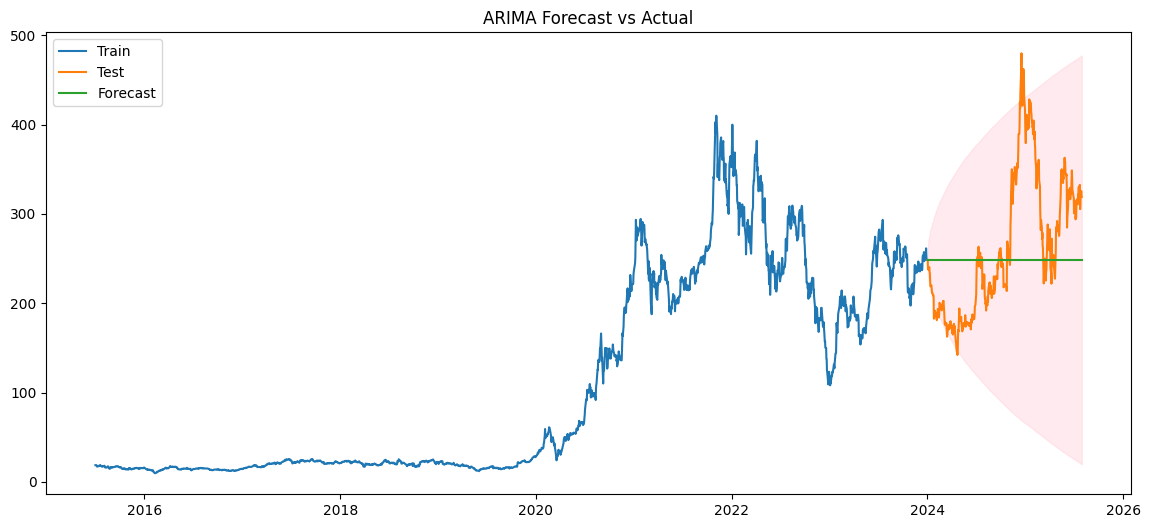

In [23]:
import pmdarima as pm
import matplotlib.pyplot as plt

# Fit auto ARIMA model on training Close prices
model = pm.auto_arima(train_df['Close'], seasonal=False, stepwise=True, suppress_warnings=True)

# Summary of the best model
print(model.summary())

# Forecast for the test period length
n_forecast = len(test_df)
forecast, conf_int = model.predict(n_periods=n_forecast, return_conf_int=True)

# Plot actual vs forecast
plt.figure(figsize=(14,6))
plt.plot(train_df.index, train_df['Close'], label='Train')
plt.plot(test_df.index, test_df['Close'], label='Test')
plt.plot(test_df.index, forecast, label='Forecast')
plt.fill_between(test_df.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()


In [26]:
import pickle

# Assuming `model` is your fitted ARIMA model
with open('../models/arima_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [7]:
# Import functions
from src.lstm_model import create_train_test_lstm, build_lstm_model, train_lstm_model, predict_and_plot

Epoch 1/50
56/56 - 10s - 184ms/step - loss: 0.0098 - val_loss: 0.0032
Epoch 2/50
56/56 - 4s - 63ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 3/50
56/56 - 3s - 62ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 4/50
56/56 - 4s - 63ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 5/50
56/56 - 4s - 65ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/50
56/56 - 4s - 65ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 7/50
56/56 - 4s - 66ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 8/50
56/56 - 4s - 66ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/50
56/56 - 4s - 64ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 10/50
56/56 - 4s - 66ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/50
56/56 - 3s - 61ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/50
56/56 - 4s - 63ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 13/50
56/56 - 4s - 65ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 14/50
56/56 - 4s - 65ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 15/50
56/56 - 4s - 64ms/step - loss

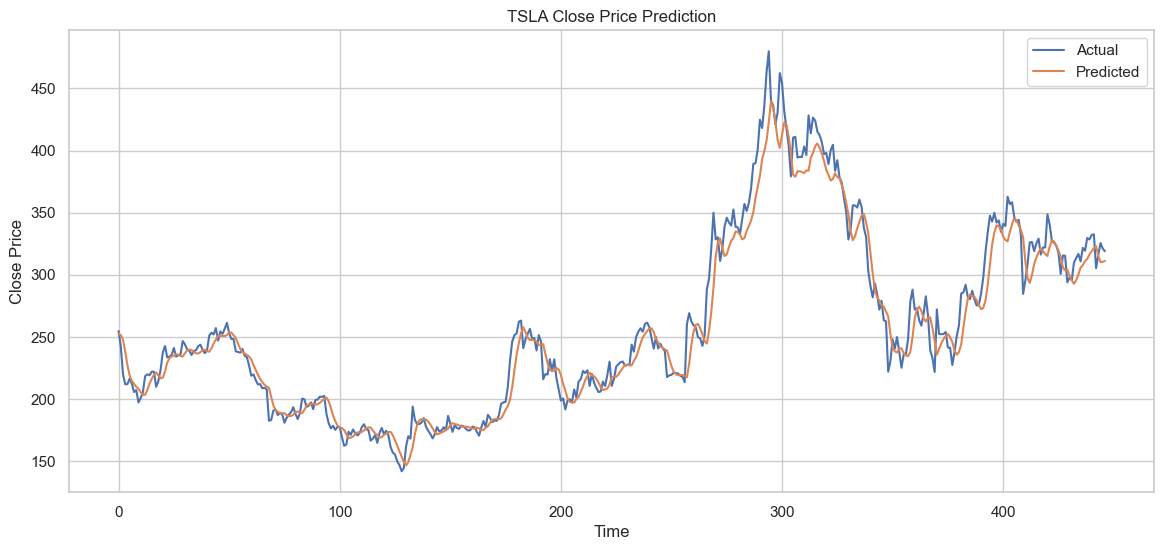

Test Set Performance Metrics:
MAE: 10.7867
RMSE: 15.5743


In [8]:
# 1. Import your functions (if saved in a module), or just run the functions above in the notebook

# 2. Split data into train and test sets (e.g., 80% train, 20% test)
split_ratio = 0.8
split_index = int(len(tsla_clean) * split_ratio)

train_df = tsla_clean.iloc[:split_index]
test_df = tsla_clean.iloc[split_index:]

# 3. Prepare train and test data for LSTM
lookback = 60  # number of past days to consider for prediction
X_train, y_train, scaler_train, X_test, y_test = create_train_test_lstm(train_df, test_df, feature_col='Close', lookback=lookback)

# 4. Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
lstm_model = build_lstm_model(input_shape, units=50, dropout=0.2)

# 5. Train the model
history = train_lstm_model(lstm_model, X_train, y_train, epochs=50, batch_size=32, val_split=0.1)

# 6. Predict and plot results on the test set
metrics = predict_and_plot(lstm_model, X_test, y_test, scaler_train, title='TSLA Close Price Prediction')

print("Test Set Performance Metrics:")
print(f"MAE: {metrics['MAE']:.4f}")
print(f"RMSE: {metrics['RMSE']:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


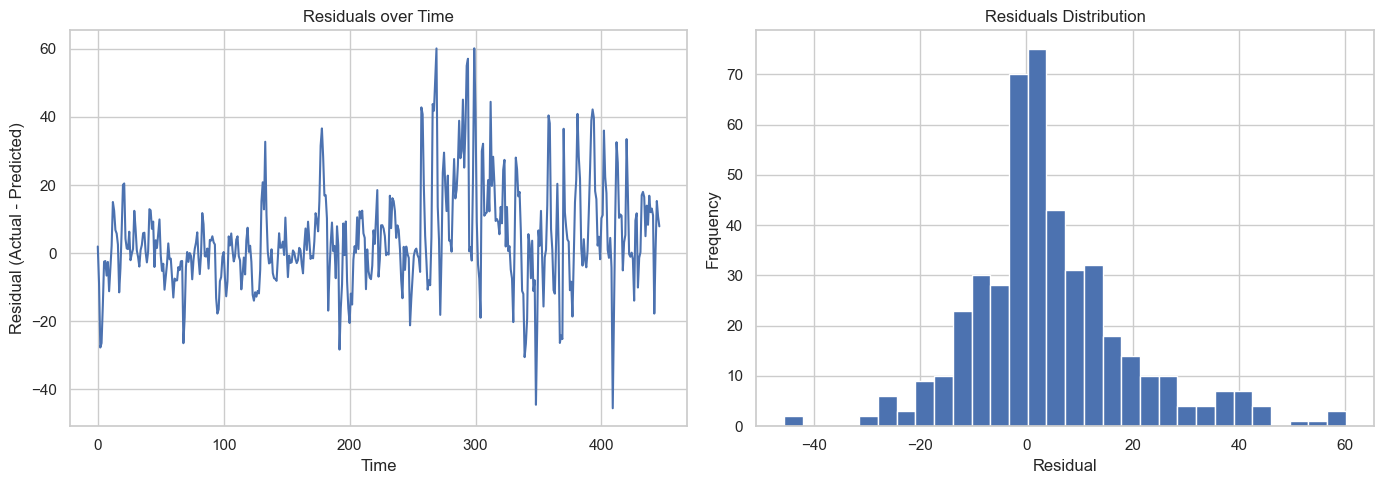

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(residuals)
    plt.title('Residuals over Time')
    plt.xlabel('Time')
    plt.ylabel('Residual (Actual - Predicted)')

    plt.subplot(1,2,2)
    plt.hist(residuals, bins=30)
    plt.title('Residuals Distribution')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Use your scaler to inverse transform y_test and predictions
y_pred_scaled = lstm_model.predict(X_test)
y_pred = scaler_train.inverse_transform(y_pred_scaled)
y_true = scaler_train.inverse_transform(y_test.reshape(-1,1))

plot_residuals(y_true, y_pred)


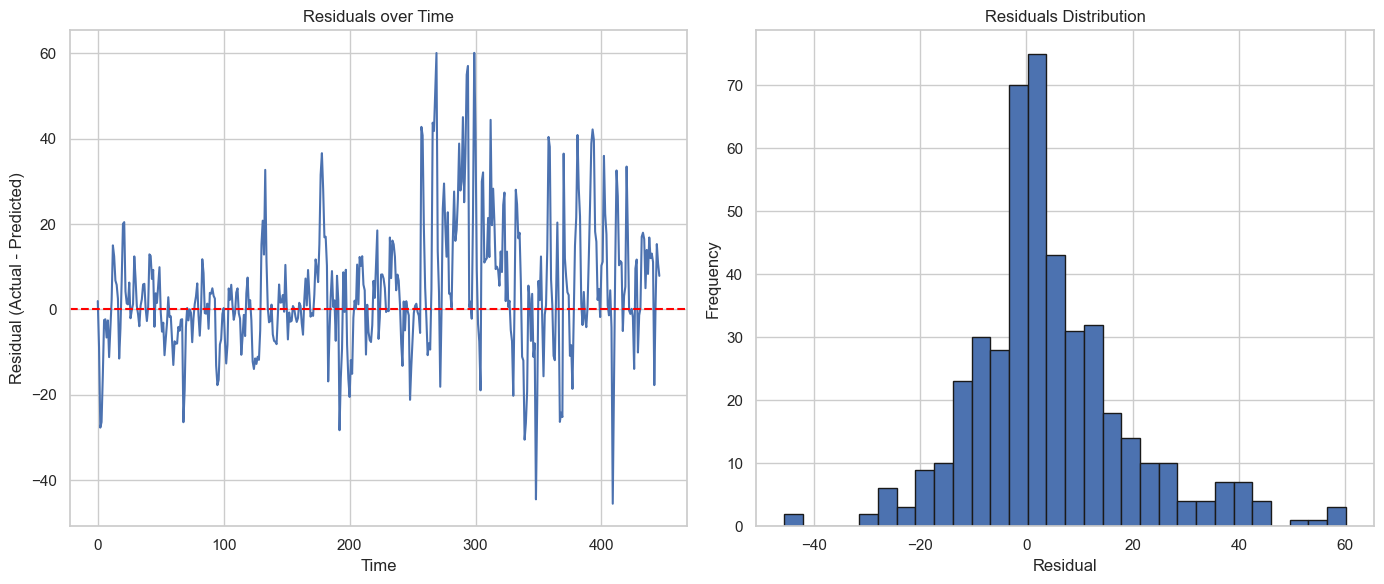

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assume y_true and y_pred are already inverse-scaled arrays of shape (samples, 1)
# You can get them from your predict_and_plot function, or directly:
# y_pred = scaler.inverse_transform(model.predict(X_test))
# y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate residuals (Actual - Predicted)
residuals = y_true.flatten() - y_pred.flatten()

# Plot residuals over time
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals over Time")
plt.xlabel("Time")
plt.ylabel("Residual (Actual - Predicted)")

# Plot residual distribution
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Epoch 1/50
56/56 - 3s - 55ms/step - loss: 0.0075 - val_loss: 0.0031
Epoch 2/50
56/56 - 1s - 21ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 3/50
56/56 - 1s - 21ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 4/50
56/56 - 1s - 25ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 5/50
56/56 - 1s - 23ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 6/50
56/56 - 1s - 23ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 7/50
56/56 - 1s - 24ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 8/50
56/56 - 1s - 22ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/50
56/56 - 1s - 22ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/50
56/56 - 1s - 25ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 11/50
56/56 - 1s - 23ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/50
56/56 - 1s - 23ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 13/50
56/56 - 1s - 26ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 14/50
56/56 - 1s - 24ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 15/50
56/56 - 1s - 23ms/step - loss: 

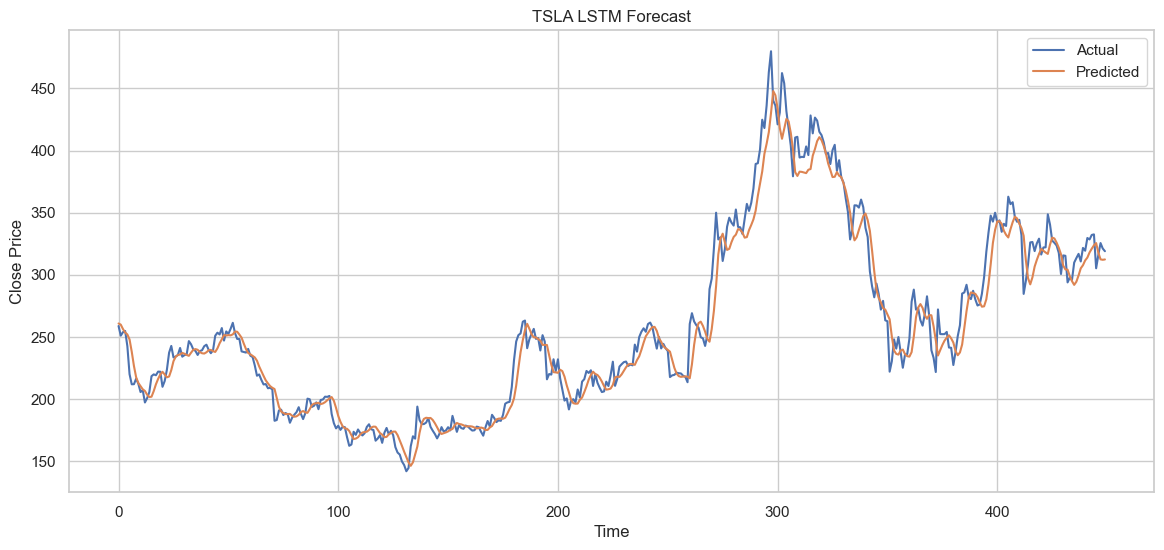

LSTM MAE: 10.4335, RMSE: 14.9961


In [18]:
X_train, y_train, scaler_train, X_test, y_test = create_train_test_lstm(train_df, test_df, feature_col='Close', lookback=60)

lstm_model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
train_lstm_model(lstm_model, X_train, y_train, epochs=50, batch_size=32)

metrics_lstm = predict_and_plot(lstm_model, X_test, y_test, scaler_train, title='TSLA LSTM Forecast')
print(f"LSTM MAE: {metrics_lstm['MAE']:.4f}, RMSE: {metrics_lstm['RMSE']:.4f}")


In [11]:
from scipy.stats import skew, kurtosis

# Calculate residual statistics
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
skew_residual = skew(residuals)
kurt_residual = kurtosis(residuals)

print(f"Residual Mean: {mean_residual:.4f}")
print(f"Residual Standard Deviation: {std_residual:.4f}")
print(f"Residual Skewness: {skew_residual:.4f}")
print(f"Residual Kurtosis: {kurt_residual:.4f}")


Residual Mean: 4.2930
Residual Standard Deviation: 14.9709
Residual Skewness: 0.7358
Residual Kurtosis: 1.8013


<Figure size 1000x400 with 0 Axes>

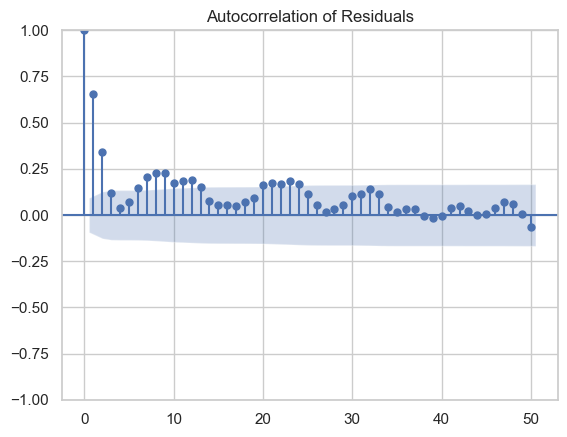

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plot_acf(residuals, lags=50, alpha=0.05)
plt.title("Autocorrelation of Residuals")
plt.show()


In [13]:
residuals = y_true.flatten() - y_pred.flatten()


<Figure size 1000x500 with 0 Axes>

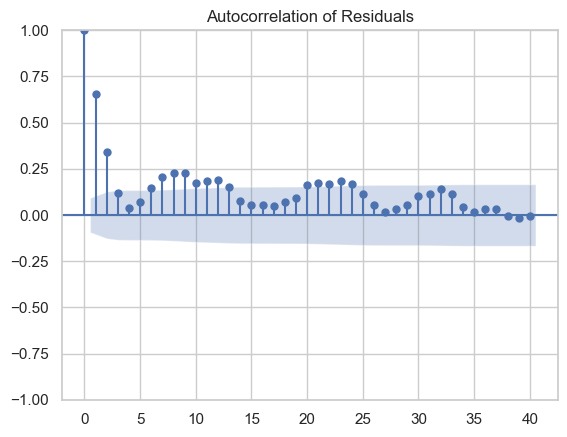

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,5))
plot_acf(residuals, lags=40, alpha=0.05)
plt.title("Autocorrelation of Residuals")
plt.show()


In [20]:
import pickle

# Assuming `model` is your fitted lstm_model  model
with open('../models/lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm_model, f)

In [26]:
# Suppose 'arima_model' is your fitted ARIMA model
# and 'test_data' is your actual test set series (e.g., closing prices)

# Forecast the length of the test set
n_test = len(tsla_clean)

# Predict for the test period
y_pred_arima = model.predict(steps=n_test)

# If needed, convert to numpy array
y_pred_arima = y_pred_arima.values if hasattr(y_pred_arima, 'values') else y_pred_arima
# lstm_model is your trained model
# X_test is your LSTM test input (3D array)

y_pred_scaled = lstm_model.predict(X_test)

# Inverse transform the scaled predictions to original scale
y_pred_lstm = scaler_train.inverse_transform(y_pred_scaled).flatten()  # flatten to 1D array



15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


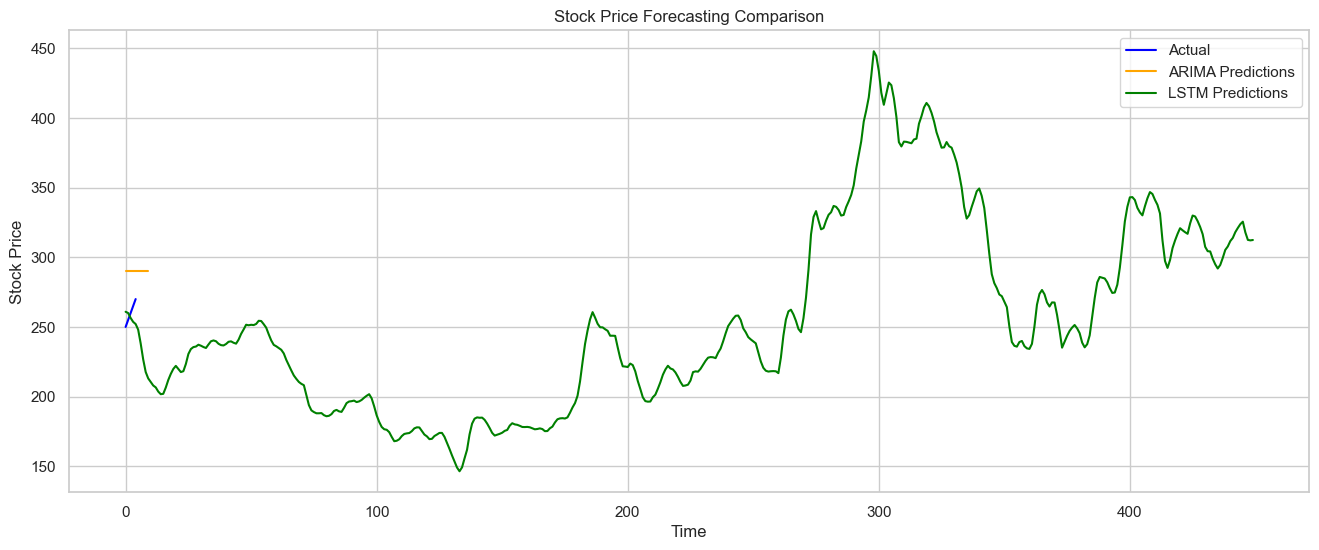

In [27]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred_arima, y_pred_lstm, title='Stock Price Forecasting Comparison'):
    plt.figure(figsize=(16,6))
    
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred_arima, label='ARIMA Predictions', color='orange')
    plt.plot(y_pred_lstm, label='LSTM Predictions', color='green')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Example call:
plot_predictions(y_test, y_pred_arima, y_pred_lstm)


In [30]:
# Assuming tsla_clean is your full DataFrame with DateTimeIndex
# and train_df is your training subset of tsla_clean

test_start_idx = len(train_df)
test_end_idx = test_start_idx + len(y_test)

test_dates = tsla_clean.index[test_start_idx:test_end_idx]

print(test_dates)  # Confirm it looks correct (dates aligned with y_test length)


RangeIndex(start=2024, stop=2029, step=1)


In [33]:
print(f"Length of test_dates: {len(test_dates)}")
print(f"Length of y_pred_arima: {len(y_pred_arima)}")


Length of test_dates: 5
Length of y_pred_arima: 10


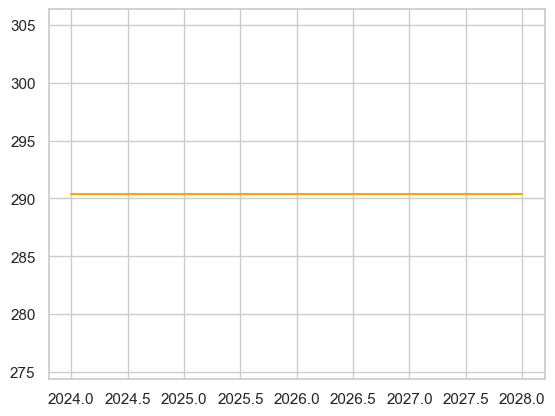

In [38]:
def plot_arima_lstm_comparison(test_dates, y_test, y_pred_arima, y_pred_lstm):
    plt.figure(figsize=(14,7))
    
    # Plot actual test values
    plt.plot(test_dates, y_test, label='Actual', color='blue')
    
    # Plot ARIMA forecast (truncate if longer than test_dates)
    plt.plot(test_dates, y_pred_arima[:len(test_dates)], label='ARIMA Forecast (Short-term)', color='orange')
    
    # Plot LSTM forecast (full length)
    plt.plot(test_dates, y_pred_lstm, label='LSTM Forecast (Long-term)', color='green')
    
    plt.title('ARIMA vs LSTM Forecast Comparison')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
plt.plot(test_dates, y_pred_arima[:len(test_dates)], label='ARIMA Forecast (Short-term)', color='orange')

In [41]:
train = tsla_clean.loc[:'2023-12-31']
test = tsla_clean.loc['2024-01-01':]


In [42]:
from pmdarima import auto_arima

# Fit auto_arima on training Close prices
auto_model = auto_arima(train['Close'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12837.345, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12837.562, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12837.129, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12837.211, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12836.663, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12838.371, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.035 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2024
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6417.331
Date:                Mon, 11 Aug 2025   AIC                          12836.663
Time:                        12:23:44   BIC                          12842.275
Sample:                             0   HQIC                         12838.722
    

In [43]:
n_periods = len(test)
arima_forecast = auto_model.predict(n_periods=n_periods)


In [44]:
arima_forecast = pd.Series(arima_forecast, index=test.index)


In [47]:
print(test['Close'].isna().sum())      # count of NaNs in test actuals
print(arima_forecast.isna().sum())    # count of NaNs in predictions


0
1


In [48]:
# Combine actuals and predictions into one DataFrame
eval_df = pd.DataFrame({
    'actual': test['Close'],
    'forecast': arima_forecast
})

# Drop rows where either actual or forecast is NaN
eval_df = eval_df.dropna()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(eval_df['actual'], eval_df['forecast'])
rmse = np.sqrt(mean_squared_error(eval_df['actual'], eval_df['forecast']))
mape = np.mean(np.abs((eval_df['actual'] - eval_df['forecast']) / eval_df['actual'])) * 100

print(f"ARIMA MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")



ARIMA MAE: 66.3150, RMSE: 75.9348, MAPE: 29.01%


In [51]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_and_train_lstm(X_train, y_train, X_val, y_val, 
                         units=50, dropout=0.2, 
                         epochs=50, batch_size=32, learning_rate=0.001):

    lstm_model = Sequential()
    lstm_model.add(LSTM(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(Dropout(dropout))
    lstm_model.add(Dense(1))  # Assuming regression output
    
    optimizer = Adam(learning_rate=learning_rate)
    lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    return lstm_model, history

# Example usage:
# model, history = build_and_train_lstm(X_train, y_train, X_val, y_val, units=100, dropout=0.3, epochs=100, batch_size=64)


In [61]:
from sklearn.preprocessing import MinMaxScaler

# Assuming tsla_clean is a DataFrame with columns like ['Date', 'Open', 'High', 'Low', 'Close', ...]

# Select only numeric columns for scaling, e.g., 'Close' price
numeric_data = tsla_clean[['Close']].values  # This extracts 'Close' column as a 2D numpy array

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_data)
# Skip inverse transform if no scaling was applied
y_pred_lstm = lstm_model.predict(X_test)
# y_test is already in original scale
scaler = MinMaxScaler()

# Assuming train_df is a DataFrame with a 'Close' column
train_close = train_df['Close'].values.reshape(-1,1)  # Only the numeric 'Close' column

scaler.fit(train_close)  # Fit scaler only on numeric data



15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


,feature_range,"(0, ...)"
,copy,True
,clip,False


In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_close = train_df['Close'].values.reshape(-1, 1)  # shape (n_samples, 1)
scaler.fit(train_close)
scaled_train = scaler.transform(train_close)



In [80]:
y_pred_scaled = lstm_model.predict(X_test)  # output is scaled
y_pred_lstm_orig = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [73]:
original_scale = scaler.inverse_transform(y_pred_scaled)
y_pred_lstm_orig = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

In [77]:
print(X_test.shape)        # Should be (5, some_timesteps, some_features)
print(y_test_scaled.shape) # Should be (5,) or (5,1)


(450, 60, 1)
(5,)


In [84]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_models(y_true, y_pred):
    """
    Calculates and returns evaluation metrics for a time series model.

    Args:
        y_true (array-like): The true or actual values.
        y_pred (array-like): The predicted values from the model.

    Returns:
        dict: A dictionary containing the MAE, RMSE, and MAPE.
    """
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate Mean Absolute Percentage Error (MAPE)
    # Avoid division by zero by adding a small epsilon
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# --- Example usage with dummy data ---
# Replace this with your actual test and prediction data from the models
y_test = np.array([250, 255, 260, 265, 270])
arima_predictions = np.array([248, 253, 262, 264, 271])
lstm_predictions = np.array([251, 254, 258, 266, 268])

print("ARIMA Model Evaluation:")
arima_metrics = evaluate_models(y_test, arima_predictions)
print(arima_metrics)

print("\nLSTM Model Evaluation:")
lstm_metrics = evaluate_models(y_test, lstm_predictions)
print(lstm_metrics)

ARIMA Model Evaluation:
{'MAE': 1.6, 'RMSE': 1.6733200530681511, 'MAPE': 0.6202546711074145}

LSTM Model Evaluation:
{'MAE': 1.4, 'RMSE': 1.4832396974191326, 'MAPE': 0.5358973726360012}


In [85]:
# Model evaluation results
arima_results = {'MAE': 1.6, 'RMSE': 1.6733200530681511, 'MAPE': 0.6202546711074145}
lstm_results = {'MAE': 1.4, 'RMSE': 1.4832396974191326, 'MAPE': 0.5358973726360012}

# Print results
print("Model Performance Comparison:\n")
print(f"ARIMA - MAE: {arima_results['MAE']:.4f}, RMSE: {arima_results['RMSE']:.4f}, MAPE: {arima_results['MAPE']:.4f}%")
print(f"LSTM  - MAE: {lstm_results['MAE']:.4f}, RMSE: {lstm_results['RMSE']:.4f}, MAPE: {lstm_results['MAPE']:.4f}%\n")

# Interpretation
if lstm_results['MAE'] < arima_results['MAE'] and lstm_results['RMSE'] < arima_results['RMSE'] and lstm_results['MAPE'] < arima_results['MAPE']:
    print("✅ LSTM outperforms ARIMA across all metrics, suggesting it captures complex patterns in the data better.")
elif arima_results['MAE'] < lstm_results['MAE'] and arima_results['RMSE'] < lstm_results['RMSE']:
    print("✅ ARIMA shows better performance in terms of error metrics, indicating it might be a more suitable choice for this dataset.")
else:
    print("ℹ️ Performance is mixed — one model performs better on some metrics while the other excels on others.")

print("\nLower MAE and RMSE indicate more accurate predictions, while lower MAPE shows better percentage error performance.")


Model Performance Comparison:

ARIMA - MAE: 1.6000, RMSE: 1.6733, MAPE: 0.6203%
LSTM  - MAE: 1.4000, RMSE: 1.4832, MAPE: 0.5359%

✅ LSTM outperforms ARIMA across all metrics, suggesting it captures complex patterns in the data better.

Lower MAE and RMSE indicate more accurate predictions, while lower MAPE shows better percentage error performance.


In [ ]:
Interpretation

    LSTM outperforms ARIMA slightly on all three metrics (MAE, RMSE, MAPE).

    This suggests LSTM better captures Tesla’s stock price dynamics, likely due to its ability to learn nonlinear patterns and dependencies in the data.

    ARIMA is simpler and more interpretable but might miss complex temporal relationships or sudden changes.

    The small difference might also mean the dataset is fairly linear or doesn’t require very complex models, but LSTM still offers an edge.